# Loading libraries

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats
import shapefile as shp
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

# Loading Data

In [2]:
#TUDATA
df = pd.read_csv("TUDataset05061516.csv",encoding='iso8859_10')
df = df.loc[df['choice']==1]
df['Datetime'] = df.apply(lambda x: dt.datetime(1970, 1, 1)+ dt.timedelta(days=x['DiaryDate']) , axis=1, result_type='expand')
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Weekday'] = df['Datetime'].dt.weekday
df['Day'] = df['Datetime'].dt.day
df['kids'] = df['HousehNumPers'] - df['HousehNumAdults']

#Shapefiles data
sf = shp.Reader('KOMMUNE.shp',encoding='iso8859_10')
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]
df_sf = pd.DataFrame(columns=fields, data=records)
df_sf['coords'] = shps
df_sf['KOMKODE'] = df_sf['KOMKODE'].astype(int)
df_sf = df_sf.loc[df_sf['KOMKODE'] != 411]

#Population Density
df_popdens = pd.read_csv("BefolkningsTæthed.csv",sep=';',encoding='iso8859_10')

# Plotting Functions

In [3]:
def plotshapefilesdenmarkdata(data,title,integer):
    temp = []
    for i in df_sf.index:
        for j in range(len(data)):
            if data.index[j] == df_sf['KOMKODE'][i]:
                temp.append(data[data.index[j]])
    df_sf['data'] = temp
    color_sq = ['#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494']
    colors = 'YlGnBu'
    new_data, bins = pd.qcut(df_sf['data'], 6, retbins=True, labels=list(range(6)))
    color_ton = []
    for val in new_data:
        color_ton.append(color_sq[val])
    df_sf['color'] = color_ton
    colors = sns.color_palette(colors, n_colors=6)
    sns.palplot(colors, 0.6)
    if integer == 1:
        for i in range(6):
            print ("\n"+str(i+1)+': '+str(int(bins[i]))+" => "+str(int(bins[i+1])-1), end =" ")
        print("\n\n   1   2   3   4   5   6")
    else:
        for i in range(6):
            print ("\n"+str(i+1)+': '+str(bins[i])+" => "+str(bins[i+1]), end =" ")
        print("\n\n   1   2   3   4   5   6")

    plt.figure(figsize=(25,18))
    for j in df_sf.index:
        x = []
        y = []
        for i in range(len(df_sf.coords[j])):
            x.append(df_sf.coords[j][i][0])
            y.append(df_sf.coords[j][i][1])
        plt.plot(x,y,color='black')
        plt.fill(x,y,color=df_sf['color'][j])
        plt.title(title)

# Motivation

* What is your dataset?

Our dataset is data from the Transport Examination (TU-data) in Denmark (https://www.cta.man.dtu.dk/transportvaneundersoegelsen). The data is about transport choices for a representive part of danish citizens.
* Why did you choose this/these particular dataset(s)?

Being Transport and Logistics students we wanted to show some cool visualization within the field of Transport and Logistics - so the goal were to combine the tools learned in this course on the exciting TU-data
* What was your goal for the end user's experience?

The goal is to show some really cool visualizations in order for the end-user to understand which transport choice are most popular within each municipality of Denmark. We also have a focus on how many kids are where in the country.

# Basic stats

* Write about your choices in data cleaning and preprocessing

We have cleaned the data, so the data left is only about the choice of transport mode. The original data contains information about the alternative transport modes, which is relevant for creating a MNL model, but for our purpose it is not relevant.

* Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

In the TU-data there are 6 different transport modes:

1. Walking
2. Biking
3. Car driving
4. Car passengers
5. Taxi
6. Public Transport

Below you can see the distribution of the different transport modes.

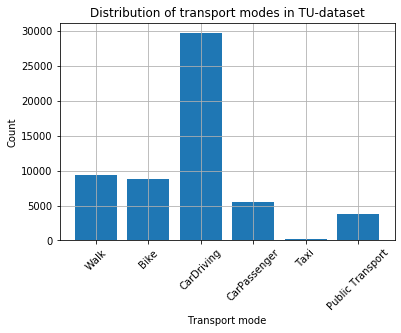

In [4]:
x = ['Walk', 'Bike', 'CarDriving', 'CarPassenger', 'Taxi','Public Transport']
plt.bar(x,df[['Walk','Bike','CarD','CarP','Taxi','Pub']].sum())
plt.grid()
plt.xlabel('Transport mode')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Distribution of transport modes in TU-dataset')
plt.show()

It is clear to see, that according to TU-data driving the car in the most popular choice in Denmark. One could argue for, that the number of observation for Public Transport is a bit low (this project is written by 3 students living in the city).

In [5]:
print("Number of observations: "+str(len(df['ID'].unique())))
print("Start date for observations: "+str(min(df['Datetime'])))
print("End date for observations: "+str(max(df['Datetime'])))

Number of observations: 57374
Start date for observations: 2006-05-12 00:00:00
End date for observations: 2016-12-31 00:00:00


This gives us 57374 observations in 10 year period. As said in the motivation section, we wanted to know more about kids in Denmark. Below you can see how many kids each household in the TU-data have.

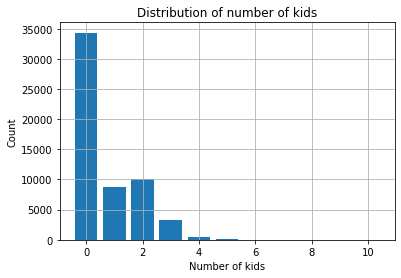

In [6]:
df['kids'] = df['HousehNumPers'] - df['HousehNumAdults']
plt.bar(df['kids'].value_counts().sort_index().index,df['kids'].value_counts().sort_index())
plt.grid()
plt.xlabel('Number of kids')
plt.ylabel('Count')
plt.title('Distribution of number of kids')
plt.show()

According to the TU-data the most popular choice is having no kids, but if you do decide to have kids, 2 kids is the most popular choice.

# Data Analysis

Starting the analysis, we wanted to show, when the transport modes are used. Below you can see a gaussian kernel density estimation for each transport mode.

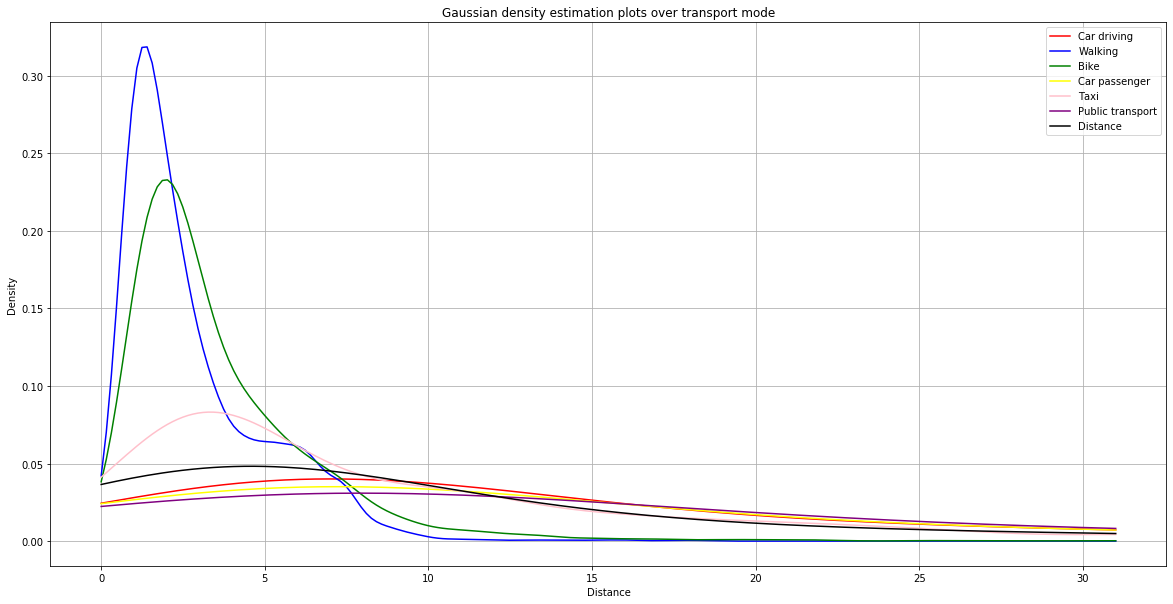

In [7]:
xs = np.linspace(0,31,200)
cov_facotr = 0.2
plt.figure(figsize=(20,10))
df_temp = df.loc[df["CarD"]==1]
density = stats.gaussian_kde(df_temp["Dist"])
density.covariance_factor = lambda : cov_facotr
density._compute_covariance()
plt.plot(xs,density(xs),color='red',label='Car driving')
df_temp = df.loc[df["Walk"]==1]
density = stats.gaussian_kde(df_temp["Dist"])
density.covariance_factor = lambda : cov_facotr
density._compute_covariance()
plt.plot(xs,density(xs),color='blue',label='Walking')
df_temp = df.loc[df["Bike"]==1]
density = stats.gaussian_kde(df_temp["Dist"])
density.covariance_factor = lambda : cov_facotr
density._compute_covariance()
plt.plot(xs,density(xs),color='green',label='Bike')
df_temp = df.loc[df["CarP"]==1]
density = stats.gaussian_kde(df_temp["Dist"])
density.covariance_factor = lambda : cov_facotr
density._compute_covariance()
plt.plot(xs,density(xs),color='yellow',label='Car passenger')
df_temp = df.loc[df["Taxi"]==1]
density = stats.gaussian_kde(df_temp["Dist"])
density.covariance_factor = lambda : cov_facotr
density._compute_covariance()
plt.plot(xs,density(xs),color='pink',label='Taxi')
df_temp = df.loc[df["Pub"]==1]
density = stats.gaussian_kde(df_temp["Dist"])
density.covariance_factor = lambda : cov_facotr
density._compute_covariance()
plt.plot(xs,density(xs),color='purple',label='Public transport')
density = stats.gaussian_kde(df["Dist"])
density.covariance_factor = lambda : cov_facotr
density._compute_covariance()
plt.plot(xs,density(xs),color='black',label='Distance')
plt.xlabel('Distance')
plt.ylabel('Density')
plt.title('Gaussian density estimation plots over transport mode')
plt.legend()
plt.grid()
plt.show()

For people who are using walking as thei transport mode, the distance has to be lower in order for the people to walk. Biking requires a bit larger distance in order to be attractive. The taxi transport mode is between biking and car driving, which makes sense, because it is expensive. Car driving, Car passenger and public transport is really flat, which means that people are using these transport modes disregarding the distance. This make sense, because you have to take public transport, if you do not own a car and you do not have to use public transport when owning a car.

We wanted to see, where in Denmark the trips are registred. Below you can see the trips within Denmark segmented on a municipaly level.


1: 14 => 218 
2: 219 => 363 
3: 364 => 446 
4: 447 => 594 
5: 595 => 756 
6: 757 => 4549 

   1   2   3   4   5   6


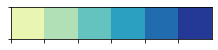

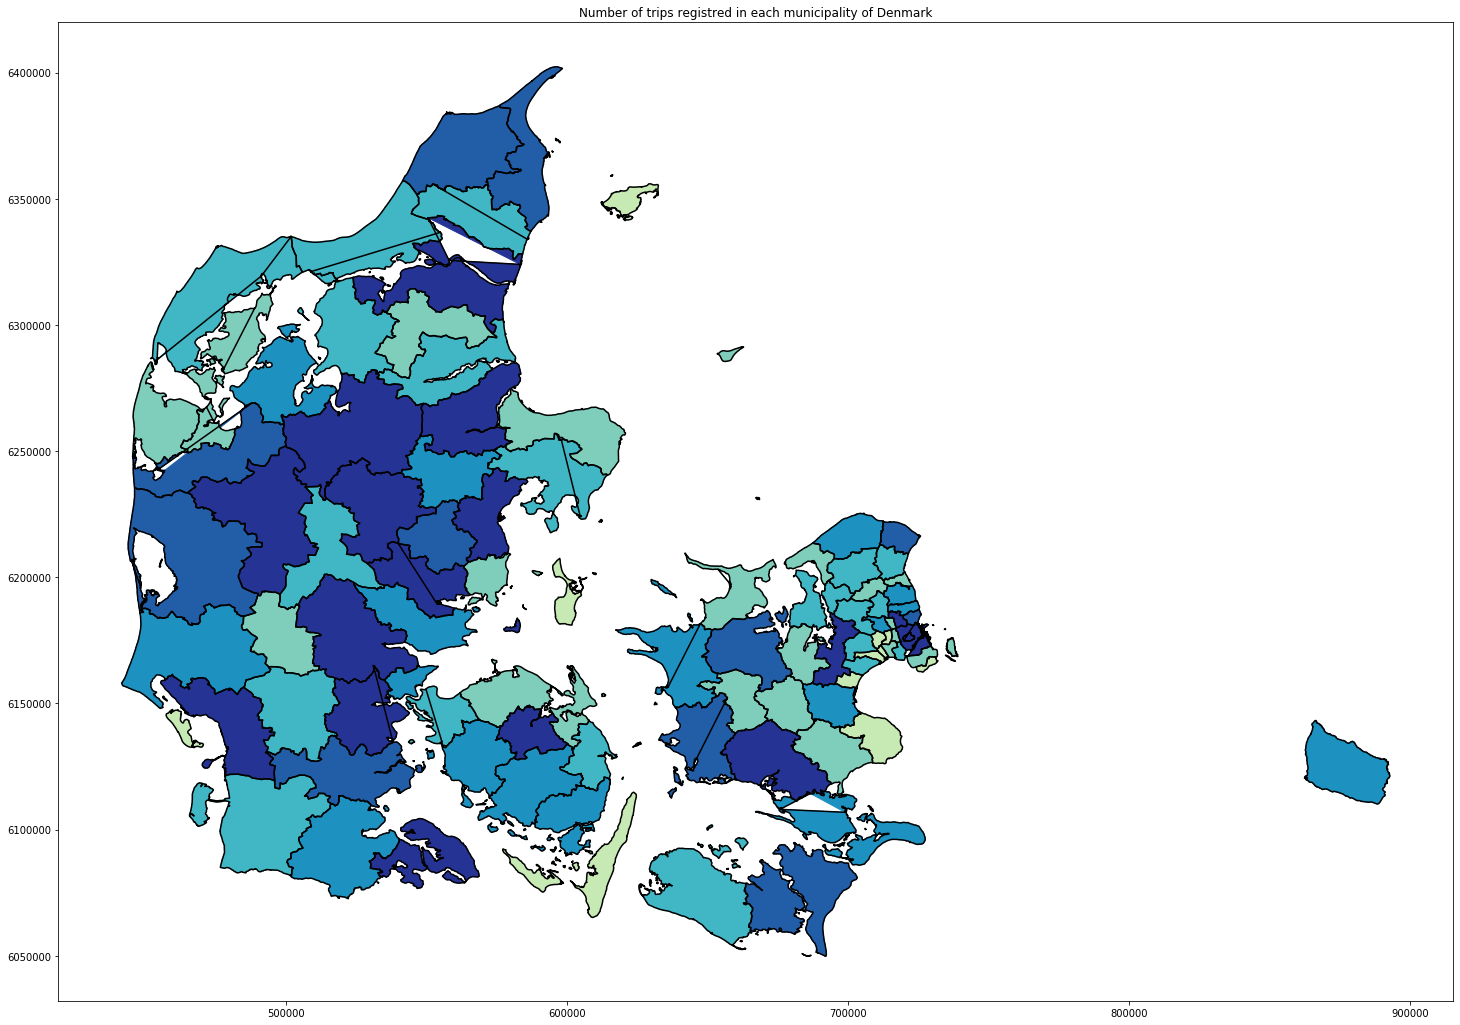

In [8]:
data = df[['HomeAdrMunCode','ID']].groupby(['HomeAdrMunCode']).count()['ID']
plotshapefilesdenmarkdata(data,'Number of trips registred in each municipality of Denmark',1)

Here we can see the distribution of trips within the TU-dataset. Most trips are in big cities. In order for the TU-dataset to be representive among Denmark, we must see, where people live in Denmark.

We have extracted data from Statistikbanken.dk (https://www.statistikbanken.dk/statbank5a/default.asp?w=1536) in order to the population in each municipality.


1: 1793 => 21346 
2: 21347 => 38096 
3: 38097 => 45035 
4: 45036 => 57021 
5: 57022 => 77819 
6: 77820 => 602480 

   1   2   3   4   5   6


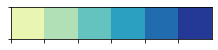

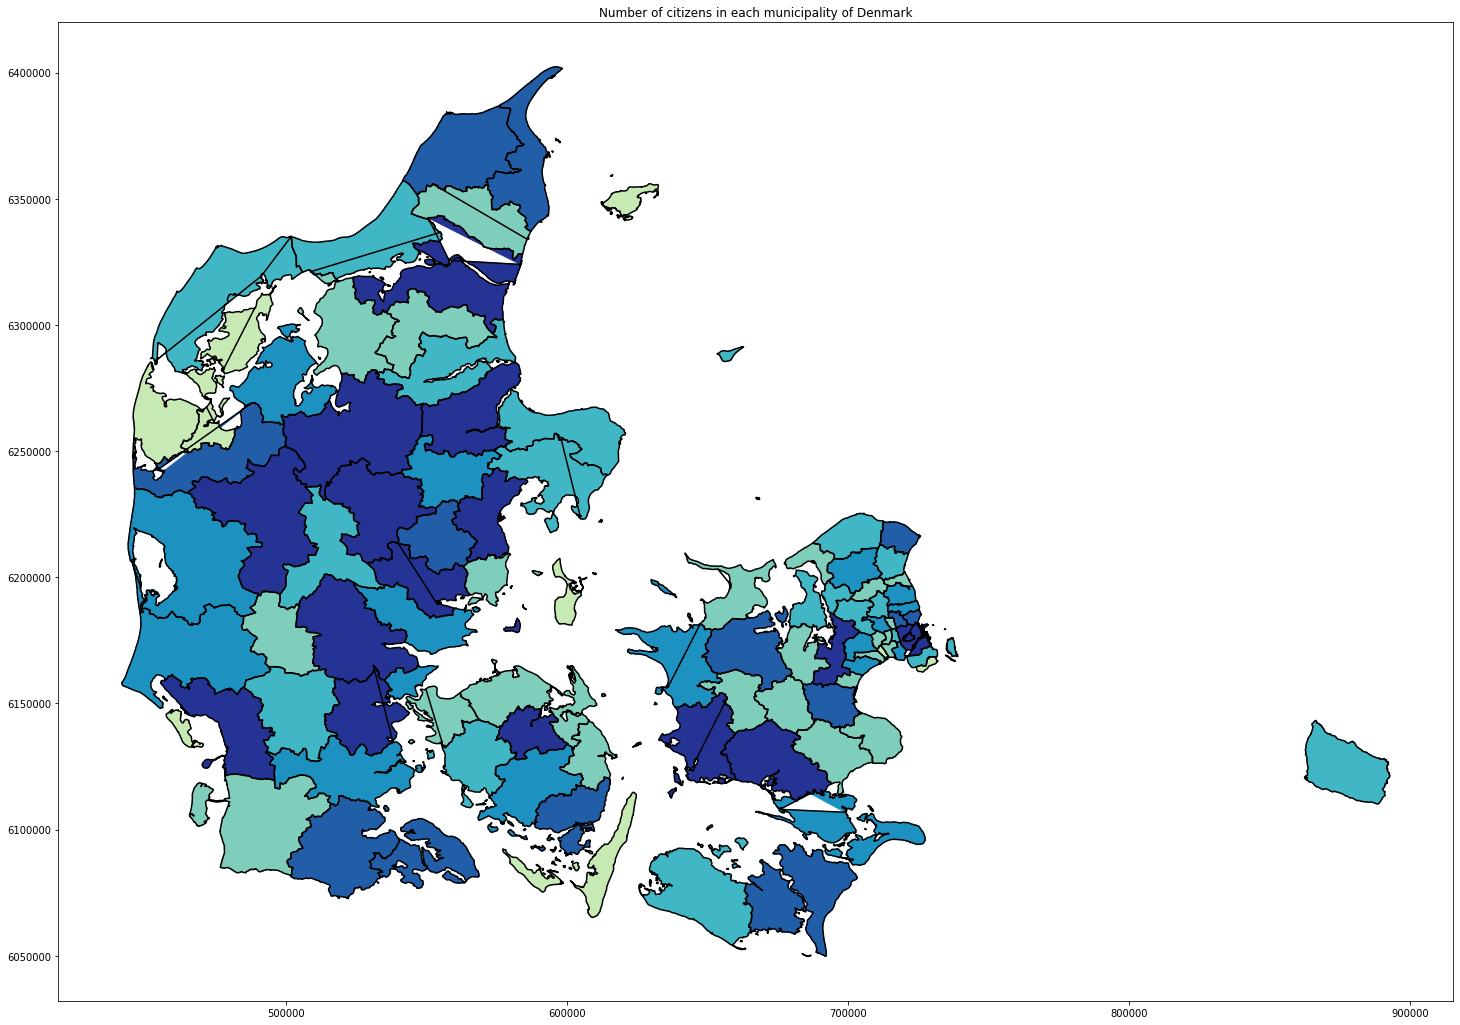

In [9]:
folketal = []
for i in df_popdens['KomKode'].unique():
    df_temp = df_popdens.loc[df_popdens['KomKode'] == i]
    folketal.append(df_temp['Folketal'].sum())
data1 = pd.Series(folketal,index=df_popdens['KomKode'].unique())
plotshapefilesdenmarkdata(data1,'Number of citizens in each municipality of Denmark',1)

As you can see, the two plot are somewhat similar, which could be an argument for, that the TU-data is represent the population of Denmark fairly well.

The next thing we show was, where the different transport mode are used. Below you can see the number of walking trips per total trips in each municipality of Denmark.

In [10]:
df_temp = df.loc[df['Walk'] == 1]
data2 = df_temp[['HomeAdrMunCode','ID']].groupby(['HomeAdrMunCode']).count()['ID']/df[['HomeAdrMunCode','ID']].groupby(['HomeAdrMunCode']).count()['ID']


1: 0.07142857142857142 => 0.11733333333333333 
2: 0.11733333333333333 => 0.13878326996197718 
3: 0.13878326996197718 => 0.14855687606112053 
4: 0.14855687606112053 => 0.15625 
5: 0.15625 => 0.17315478044222984 
6: 0.17315478044222984 => 0.28383458646616544 

   1   2   3   4   5   6


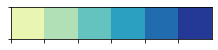

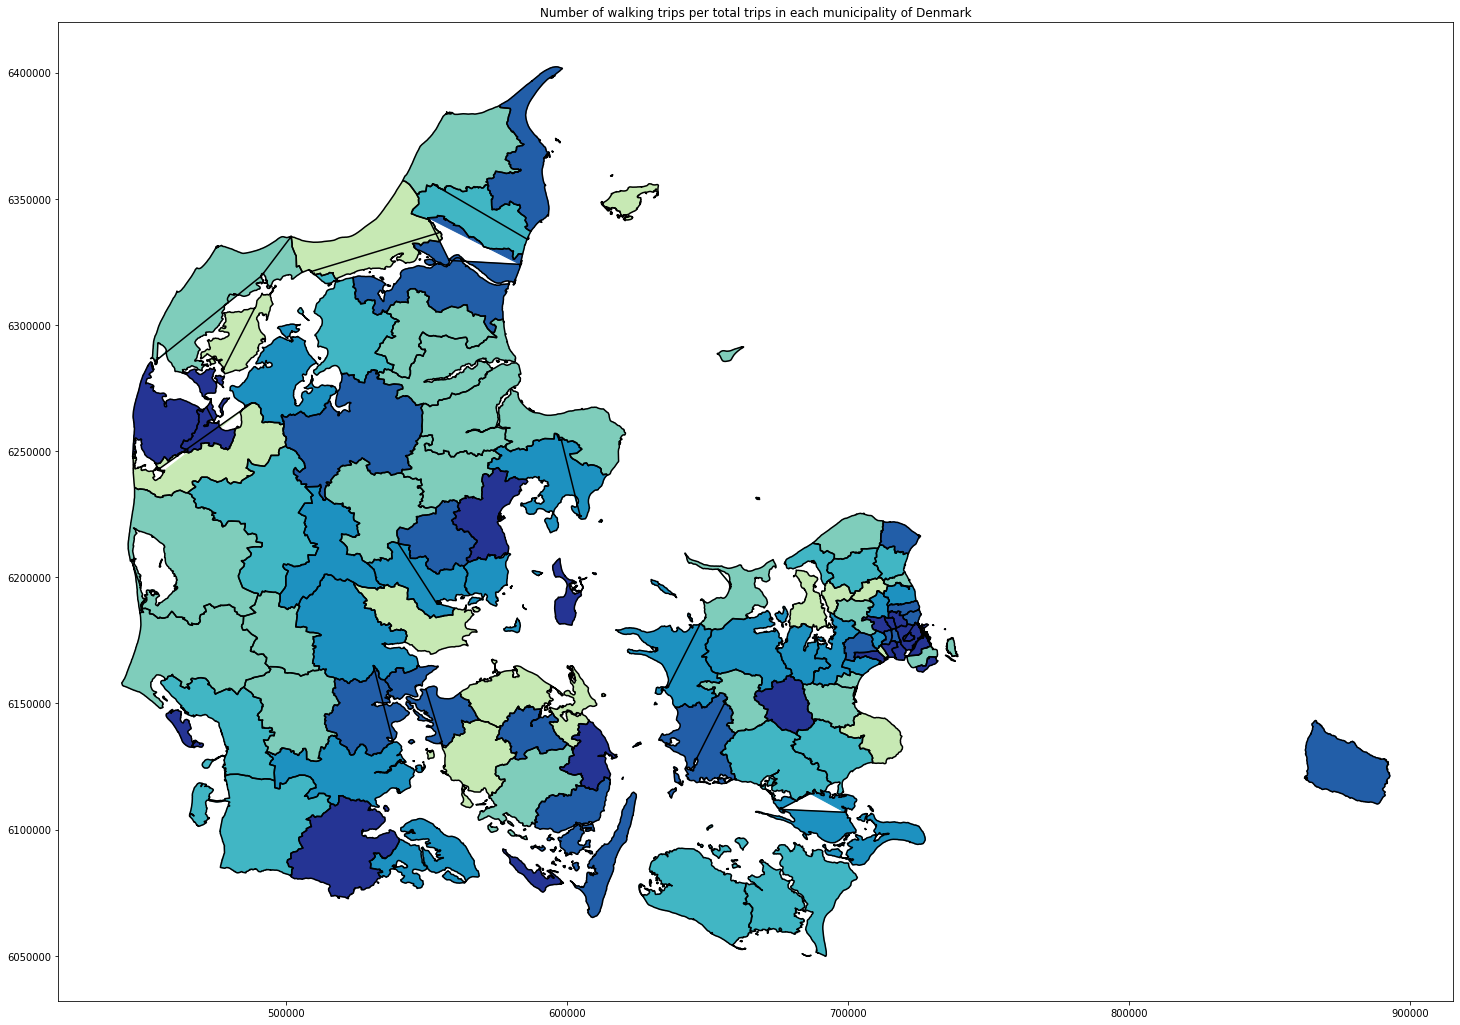

In [11]:
plotshapefilesdenmarkdata(data2,'Number of walking trips per total trips in each municipality of Denmark',0)

You can see, that people only tend to walk in the populated areas of denmark. Also there is a trend, that people more often walk, if their trip is on an island (Samsø, Bornholm etc.).

Below you can see the same analysis for bike.

In [12]:
df_temp = df.loc[df['Bike'] == 1]
data3 = df_temp[['HomeAdrMunCode','ID']].groupby(['HomeAdrMunCode']).count()['ID']/df[['HomeAdrMunCode','ID']].groupby(['HomeAdrMunCode']).count()['ID']


1: 0.042606516290726815 => 0.09486512524084778 
2: 0.09486512524084778 => 0.11166390270867882 
3: 0.11166390270867882 => 0.12903225806451613 
4: 0.12903225806451613 => 0.1525974025974026 
5: 0.1525974025974026 => 0.18690537908615776 
6: 0.18690537908615776 => 0.41304347826086957 

   1   2   3   4   5   6


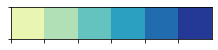

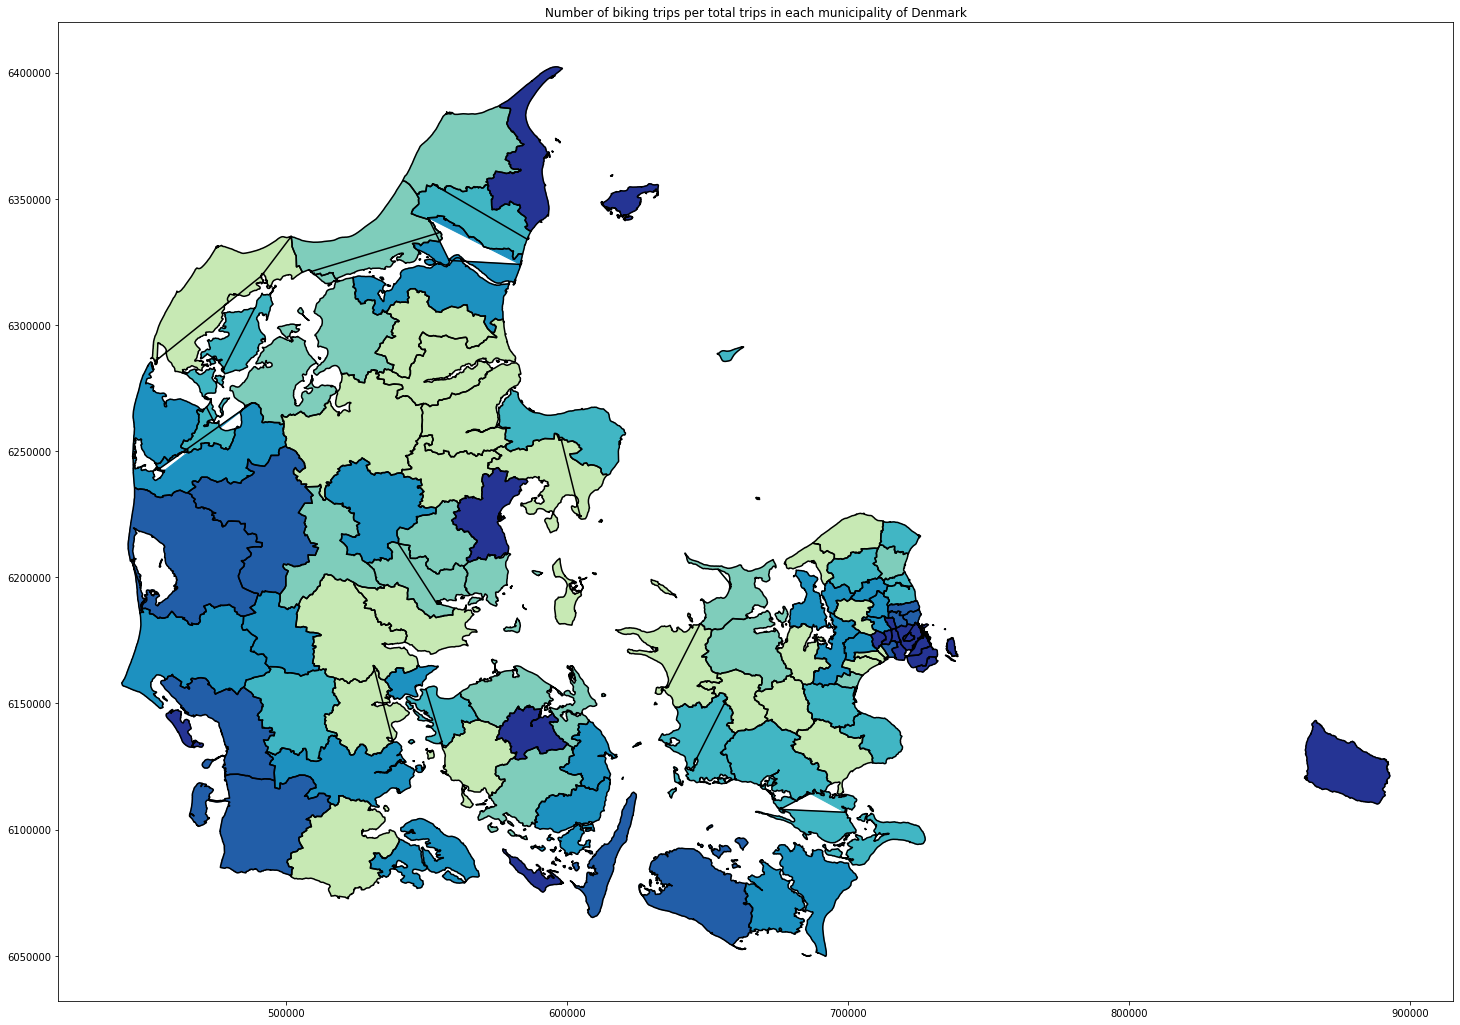

In [13]:
plotshapefilesdenmarkdata(data3,'Number of biking trips per total trips in each municipality of Denmark',0)

Again the same patterns shows, that people tend to bike more in populated or isolated areas.

Lets try with Car driving.

In [14]:
df_temp = df.loc[df['CarD'] == 1]
data4 = df_temp[['HomeAdrMunCode','ID']].groupby(['HomeAdrMunCode']).count()['ID']/df[['HomeAdrMunCode','ID']].groupby(['HomeAdrMunCode']).count()['ID']


1: 0.21052631578947367 => 0.5 
2: 0.5 => 0.5441630441630441 
3: 0.5441630441630441 => 0.5732368896925859 
4: 0.5732368896925859 => 0.5879682179341658 
5: 0.5879682179341658 => 0.6173913043478261 
6: 0.6173913043478261 => 0.707936507936508 

   1   2   3   4   5   6


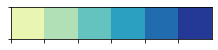

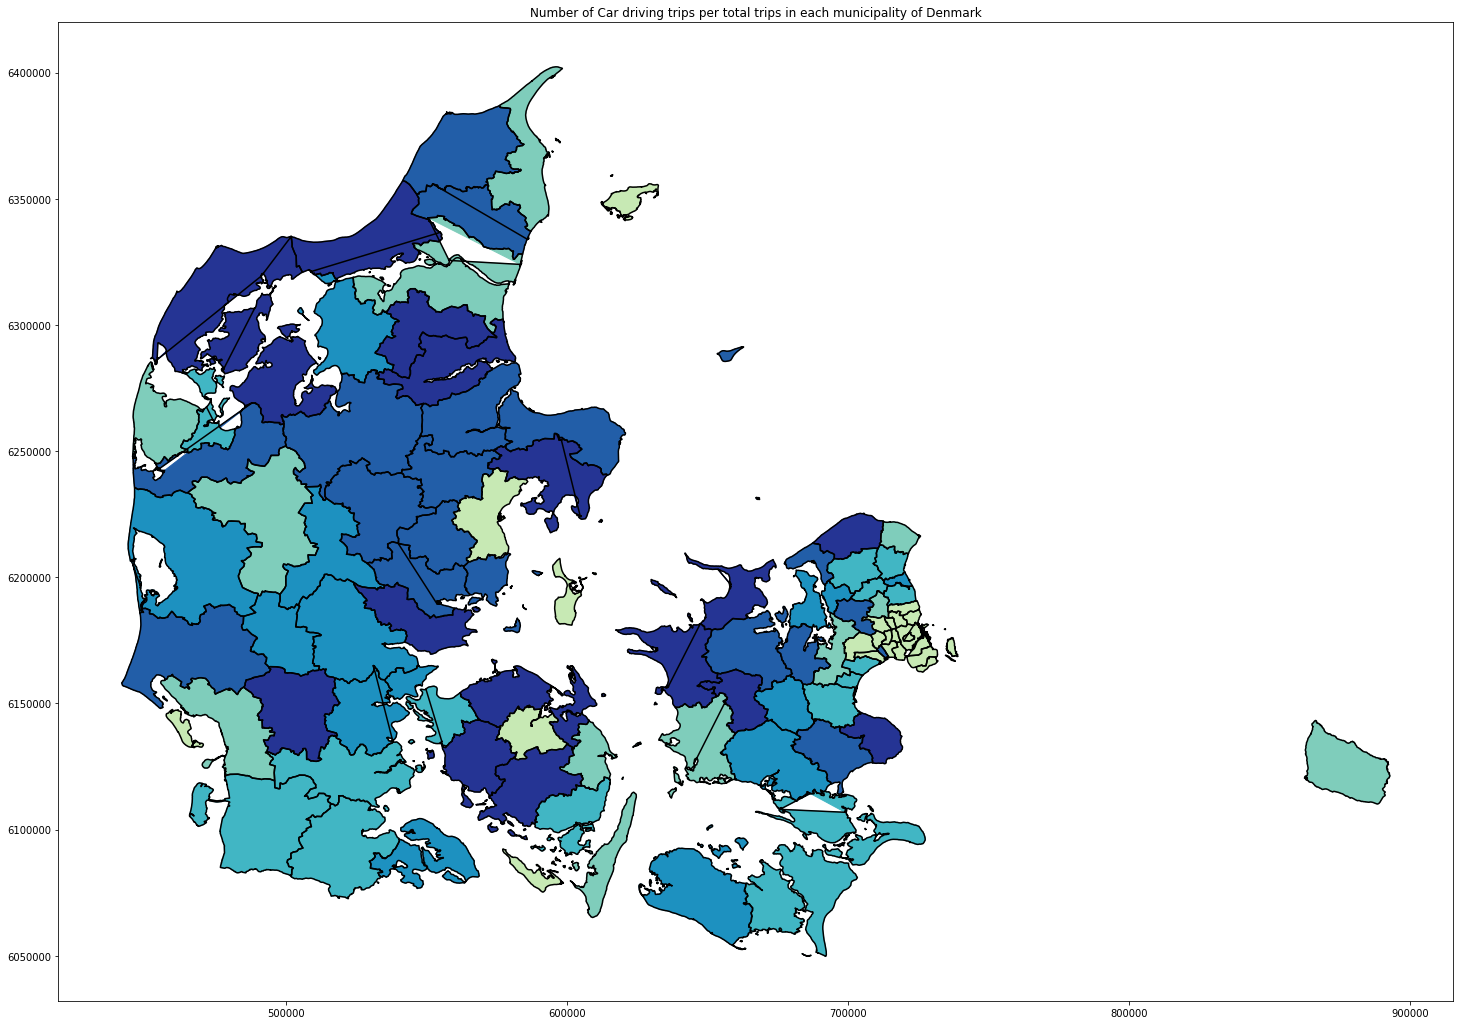

In [15]:
plotshapefilesdenmarkdata(data4,'Number of Car driving trips per total trips in each municipality of Denmark',0)

Here we can see the opposite picture, where people, who live in less populated areas uses the car as a driver most. Most businesses are within populated areas, which often means, that people have to drive to and from work, whereas people living in the cities can benefit for the smaller distance to work by biking, walking or taking public transport.

Lastly lets look at Public Transport.

In [16]:
df_temp = df.loc[df['Pub'] == 1]
test = []
for i in df['HomeAdrMunCode'].unique():
    test.append(df_temp.loc[df_temp['HomeAdrMunCode'] == i]['ID'].count())
data5 = pd.Series(test,index=df['HomeAdrMunCode'].unique())/df[['HomeAdrMunCode','ID']].groupby(['HomeAdrMunCode']).count()['ID']


1: 0.0 => 0.01881720430107527 
2: 0.01881720430107527 => 0.02794535828188088 
3: 0.02794535828188088 => 0.0392156862745098 
4: 0.0392156862745098 => 0.045083546542847214 
5: 0.045083546542847214 => 0.06477732793522267 
6: 0.06477732793522267 => 0.16593406593406593 

   1   2   3   4   5   6


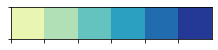

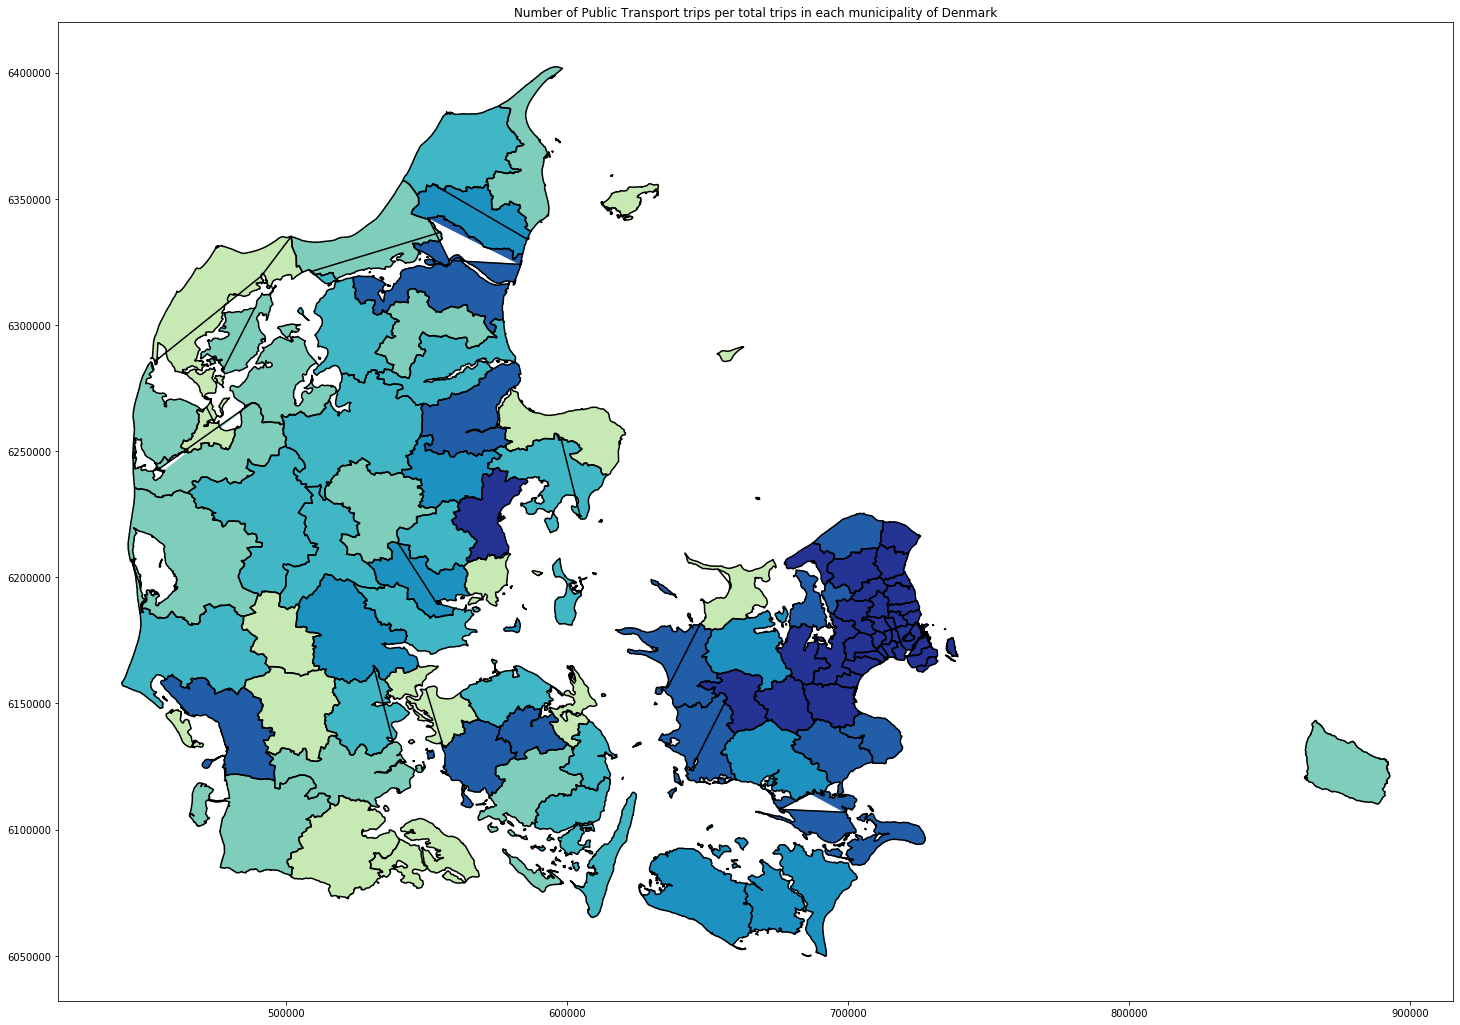

In [17]:
plotshapefilesdenmarkdata(data5,'Number of Public Transport trips per total trips in each municipality of Denmark',0)

We can see, that people are more likely to use public transport east of the great belt fixed link. This can be, beacuse the accessibility to public transport are better than Funen and Jutland. The distances in Jutland are larger generally. We also see alot of people from outside Copenhagen pendle to and from work into Copenhagen.

Know we know where the different transport modes take place, but what about when? We only have data segmented on a daily level, so lets see, where the trips take place.

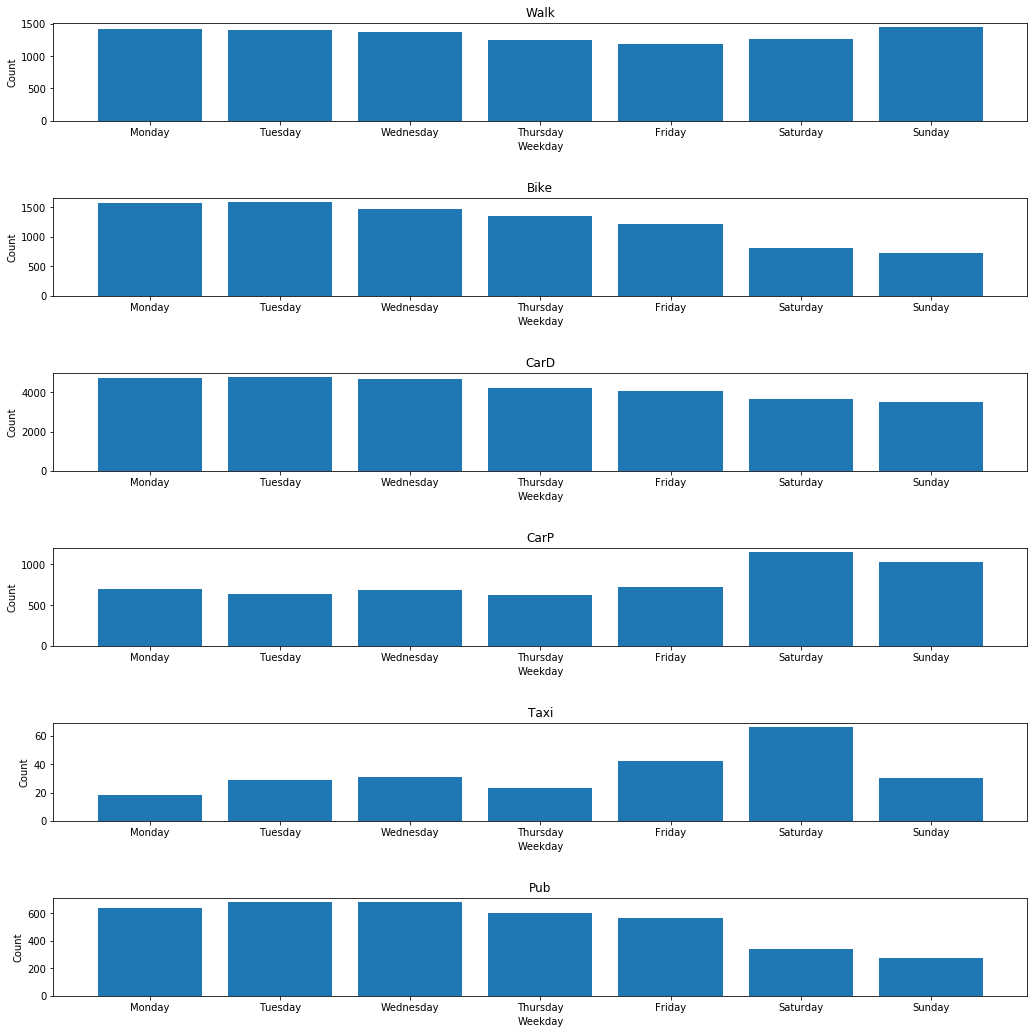

In [18]:
daynames = ['Hello','Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']

x_pos = 0

fig, axs = plt.subplots(6, 1,figsize=(15,15))

mode = ['Walk','Bike','CarD','CarP','Taxi','Pub']
for i in mode:
    df_temp = df.loc[df[i] == 1]
    df_temp = df_temp[['Weekday','ID']].groupby(['Weekday']).size()
    axs[x_pos].bar(df_temp.index,df_temp)
    axs[x_pos].set_title(i)
    axs[x_pos].set(xlabel='Weekday', ylabel='Count')
    axs[x_pos].set_xticklabels(daynames)
    x_pos = x_pos+1
fig.tight_layout(pad=3.0)

Here we can see, that the people who uses walking as their transport mode do it throughout the week. Bike is mostly uses in the working days. Car driving is used throughout the whole week, whereas Car passenger is mostly used in the weekend. Saturday is the most popular day for Taxis and public transport is mostly used in the working days. This mostly corresponds with rational behauvior according to the authors. Allthough it might be a bit wierd, that Taxis is mostly used on saturdays.

Let us segment the data on a date of the month level.

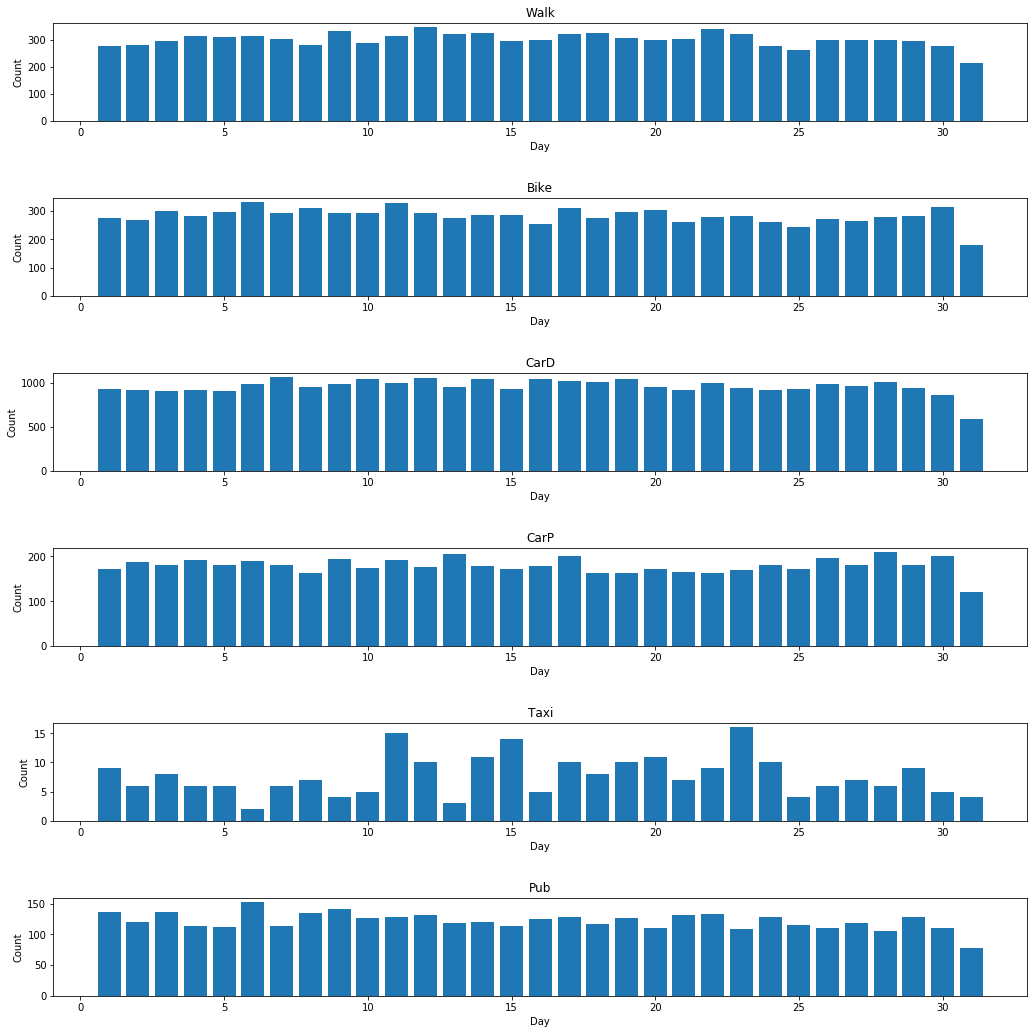

In [19]:
x_pos = 0

fig, axs = plt.subplots(6, 1,figsize=(15,15))

mode = ['Walk','Bike','CarD','CarP','Taxi','Pub']
for i in mode:
    df_temp = df.loc[df[i] == 1]
    df_temp = df_temp[['Day','ID']].groupby(['Day']).size()
    axs[x_pos].bar(df_temp.index,df_temp)
    axs[x_pos].set_title(i)
    axs[x_pos].set(xlabel='Day', ylabel='Count')
    x_pos = x_pos+1
fig.tight_layout(pad=3.0)

All the displayed data seem a bit random or evenly distributed, which would suggest, that which day of the month does not impact the choice of transport mode.

Lets see on a monthly level

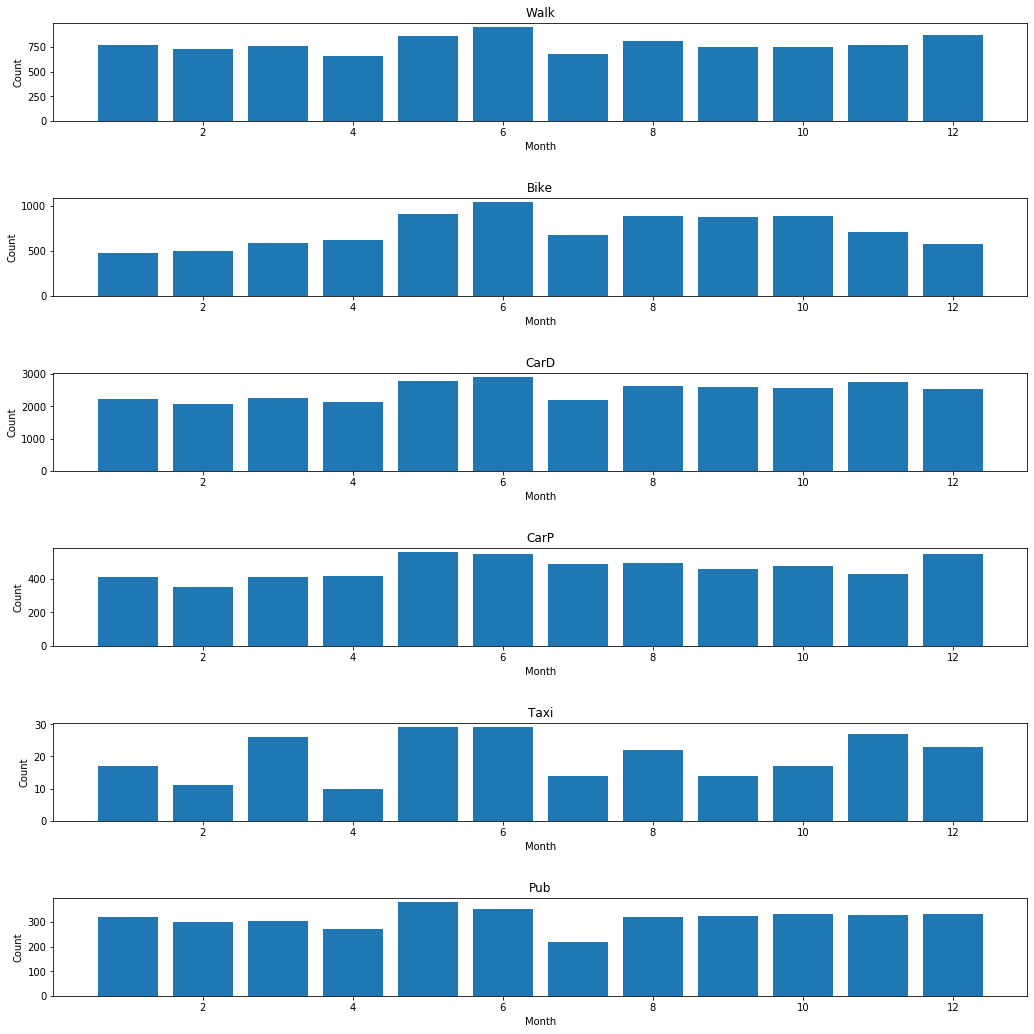

In [20]:
x_pos = 0

fig, axs = plt.subplots(6, 1,figsize=(15,15))

mode = ['Walk','Bike','CarD','CarP','Taxi','Pub']
for i in mode:
    df_temp = df.loc[df[i] == 1]
    df_temp = df_temp[['Month','ID']].groupby(['Month']).size()
    axs[x_pos].bar(df_temp.index,df_temp)
    axs[x_pos].set_title(i)
    axs[x_pos].set(xlabel='Month', ylabel='Count')
    x_pos = x_pos+1
fig.tight_layout(pad=3.0)

Here we can see some interesting trends. Walking and biking tend to be more popular in the warmer months. All modes have a decrease in use in July, which would suggest, that most households vacation in this month.

Lastly lets look, if there is a trend on a yearly basis.

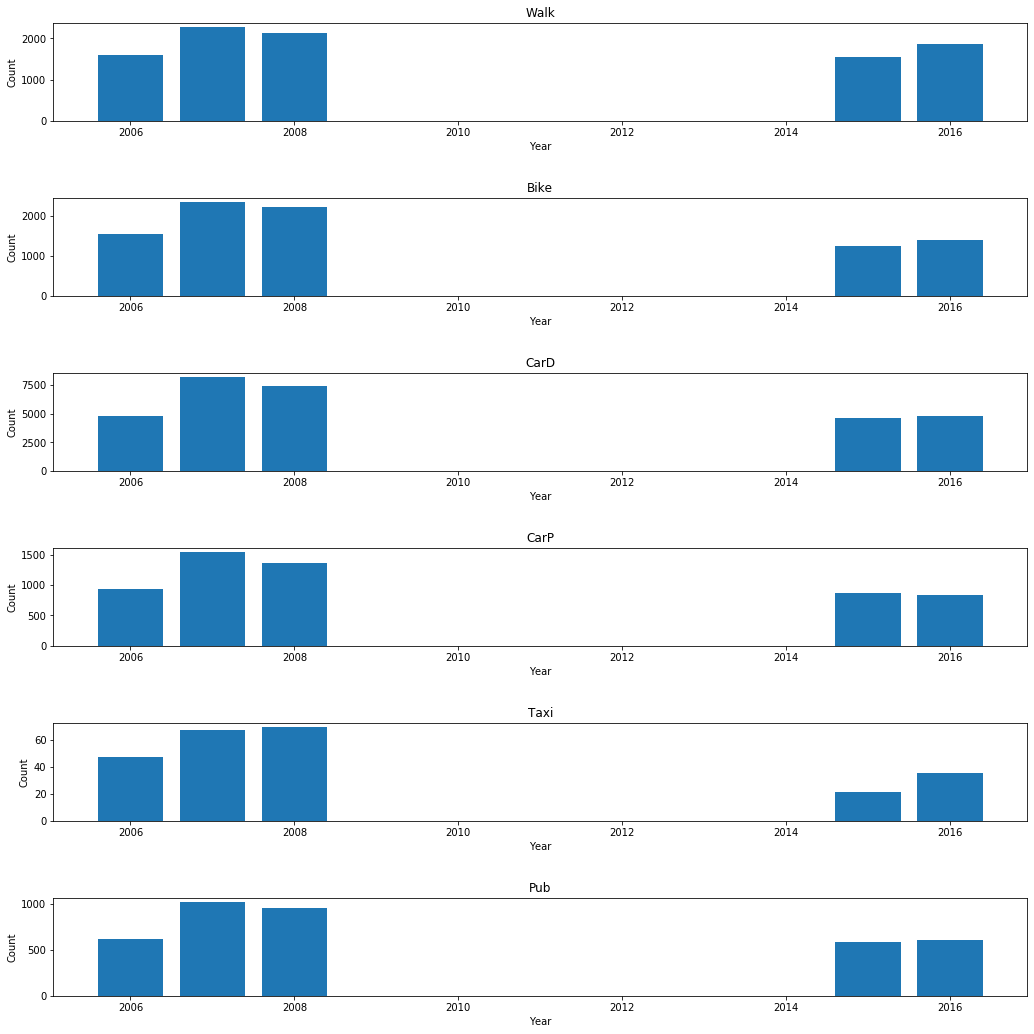

In [21]:
x_pos = 0

fig, axs = plt.subplots(6, 1,figsize=(15,15))

mode = ['Walk','Bike','CarD','CarP','Taxi','Pub']
for i in mode:
    df_temp = df.loc[df[i] == 1]
    df_temp = df_temp[['Year','ID']].groupby(['Year']).size()
    axs[x_pos].bar(df_temp.index,df_temp)
    axs[x_pos].set_title(i)
    axs[x_pos].set(xlabel='Year', ylabel='Count')
    x_pos = x_pos+1
fig.tight_layout(pad=3.0)

Here we can see, that there is a lack of data from 2009-14. And we know from before, that we started the data collection in mid 2006. So the data is quite flawed with in yearly level. There seems to be more observations from 2007 and 2008, so we can not use the data to see trends on a yearly level.

As mentiond in the beginning, we also wanted to examine how many kids and where, they are located. Below you can see the number of kids per citizens in each municipality of Denmark.

In [22]:
data6 = (df[['HomeAdrMunCode','kids']].groupby(['HomeAdrMunCode']).sum()/df[['HomeAdrMunCode','kids']].groupby(['HomeAdrMunCode']).count())['kids']


1: 0.48333333333333334 => 0.6306620209059234 
2: 0.6306620209059234 => 0.6882217090069284 
3: 0.6882217090069284 => 0.7342857142857143 
4: 0.7342857142857143 => 0.7711815592141091 
5: 0.7711815592141091 => 0.8112449799196787 
6: 0.8112449799196787 => 0.9139072847682119 

   1   2   3   4   5   6


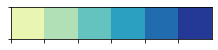

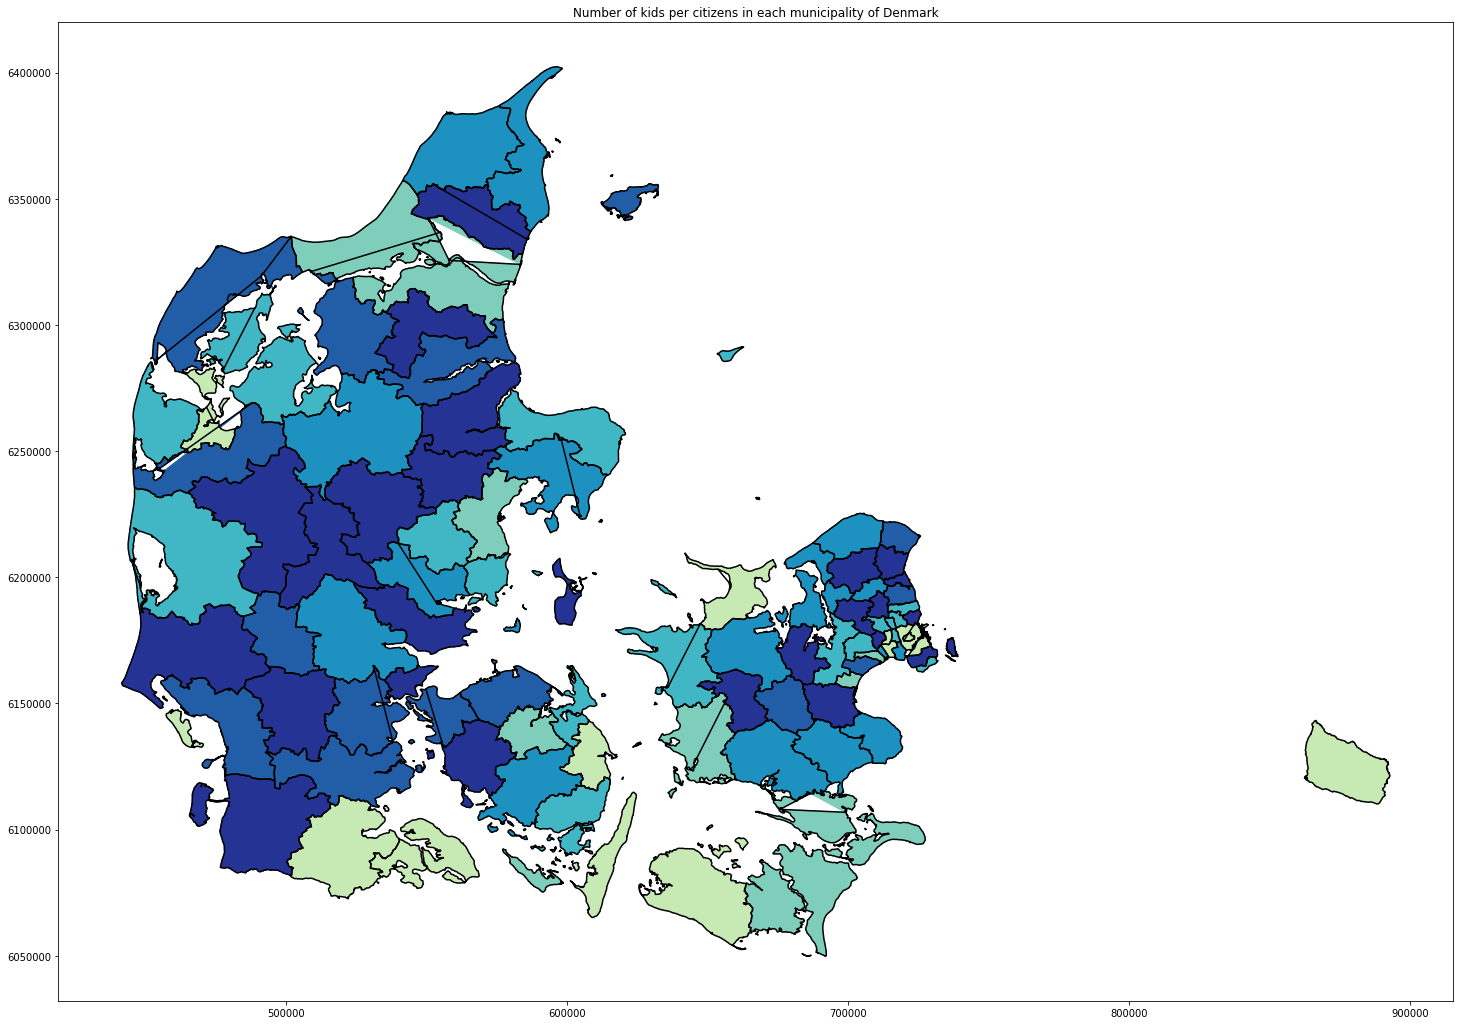

In [23]:
plotshapefilesdenmarkdata(data6,'Number of kids per citizens in each municipality of Denmark',0)

Here we can see a clear tendency, that households with kids according to TU-data move outside the three big cities (Copenhagen, Aarhus and Odense) maybe in order to enjoy more space in less populated areas.

We have seen, where and when the transport modes are used, and we have seen where in Denmark, you are more likely to run into a kid, if you see a human. But we wanted to go the step further to see, if we can predict the number of kids in a household.

In [89]:
df_temp = df[['IncRespondentImputed','NuclFamType','RespAgeCorrect','HomeAdrMunCode','kids','HousehCarOwnership']].dropna()
X = df_temp[['IncRespondentImputed','NuclFamType','RespAgeCorrect','HomeAdrMunCode','HousehCarOwnership']]
X = preprocessing.scale(X)
y = df_temp['kids']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [90]:
lr=LinearRegression()
lr.fit(X_train, y_train)
print("The accuracy of linear regression is: " + str(lr.score(X_test,y_test)))

The accuracy of linear regression is: 0.24401147777409435


In [91]:
scores = cross_val_score(lr, X_train, y_train, cv=5)
print('The average score for 5 splits: '+str(np.mean(scores)))

The average score for 5 splits: 0.2482141607295719


We have tried to predict the number of kids in a household given 5 input variables. `IncRespondentImputed` is the income for the household, `NuclFamType` is the family type (single, married etc.), `RespAgeCorrect` is the age of the surveyuser, `HomeAdrMunCode` is the municipality the user lives in and `HousehCarOwnership` is the number of cars in the household. We get a 25% succesrate, which means that model is pretty poor in predicting the number of kids in a household. We have stanardized the data. It could be, that other variables describes how many kids a household have better, than the ones we choose. Further analysis is required to obtain a better model in predicting the number of kids in a household.

Let us trying to predict the transport mode choice.

In [80]:
modes = []
for i in df.index:
    if df['Walk'][i] == 1:
        modes.append(1)
    elif df['Bike'][i] == 1:
        modes.append(2)
    elif df['CarD'][i] == 1:
        modes.append(3)
    elif df['CarP'][i] == 1:
        modes.append(4)
    elif df['Taxi'][i] == 1:
        modes.append(5)
    elif df['Pub'][i] == 1:
        modes.append(6)
df['modes'] = modes

In [98]:
df_temp = df[['IncRespondentImputed','RespAgeCorrect','HousehCarOwnership','cost1','time1','modes','HomeAdrMunCode']].dropna()
X = df_temp[['IncRespondentImputed','RespAgeCorrect','HousehCarOwnership','cost1','time1','HomeAdrMunCode']]
X_std = (X-X.mean())/X.std()
y = df_temp['modes']
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33)

In [99]:
lr1=LogisticRegression()
lr1.fit(X_train, y_train)
print("The accuracy of logistic regression is: " + str(lr1.score(X_test,y_test)))

C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


The accuracy of logistic regression is: 0.7305579036348268


In [100]:
scores = cross_val_score(lr1, X_train, y_train, cv=5)
print('The average score for 5 splits: '+str(np.mean(scores)))

C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\jakob\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

The average score for 5 splits: 0.7239778475033132


We can see, that it has a succesrate of 72% with logistic regression on the basis of `IncRespondentImputed`, `RespAgeCorrect`, `HousehCarOwnership`,`HomeAdrMunCode`, `cost1` and `time1`. Where `cost1` is the cost of the transport mode and `time1` is the time for the transport mode. So we have a better model than predicting the number of kids. Other models such as the KNNClassifier have been tried with the same result as logistic regression. But lets look closer on the prediction error. We want to plot where in the country the error are most likely to occur.

In [105]:
df_temp = X_test*X.std()+X.mean()
df_temp['real'] = y_test
df_temp['predict'] = lr1.predict(X_test)

In [120]:
failure = []
for i in df_temp.index:
    if df_temp['real'][i] == df_temp['predict'][i]:
        failure.append(0)
    else:
        failure.append(1)
df_temp['failure'] = failure

In [125]:
df_temp['HomeAdrMunCode'] = df_temp['HomeAdrMunCode'].astype(int)

In [133]:
data7 = (df_temp[['HomeAdrMunCode','failure']].groupby(['HomeAdrMunCode']).sum()/df_temp[['HomeAdrMunCode','failure']].groupby(['HomeAdrMunCode']).count())['failure']


1: 0.11235955056179775 => 0.19760479041916168 
2: 0.19760479041916168 => 0.21428571428571427 
3: 0.21428571428571427 => 0.24324324324324326 
4: 0.24324324324324326 => 0.2537313432835821 
5: 0.2537313432835821 => 0.2750892919672246 
6: 0.2750892919672246 => 0.42133333333333334 

   1   2   3   4   5   6


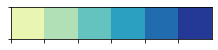

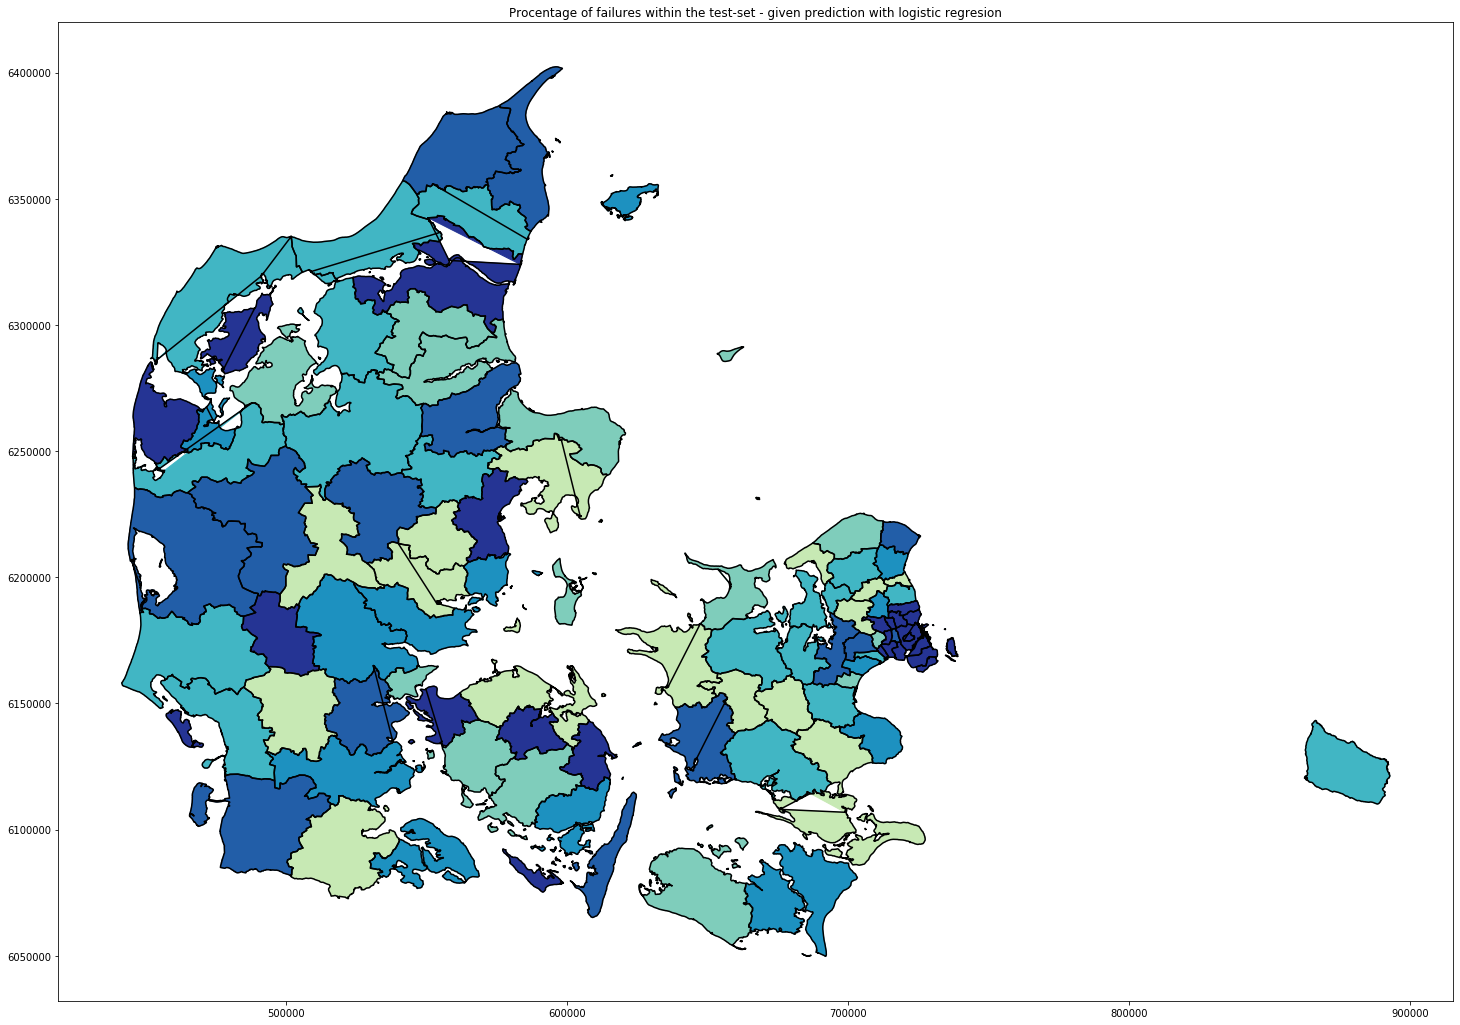

In [136]:
plotshapefilesdenmarkdata(data7,'Procentage of failures within the test-set - given prediction with logistic regresion',0)

Here we can see, where in the country an error are most likely to occur. We can see, that in populated areas the model predicts less accurate, than in the less populated areas. This could also give us an idea to know which variables to include to improve the model. Maybe even created a variable, that say something about living in populated areas?

# Genre

* Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
* Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

# Visualizations

* Explain the visualizations you've chosen.
* Why are they right for the story you want to tell?

# Discussion

* What went well?,
* What is still missing? What could be improved?, Why?

# Contributions

* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
* It is not OK simply to write "All group members contributed equally".